<a href="https://colab.research.google.com/github/LavanyaShivamurthy/myCoLabLearing/blob/main/myMultiTaskModel_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [ ]:
low_memory = False

In [ ]:
file_path= '/content/drive/MyDrive/DataSets/ICUMonitoring.csv'

In [ ]:
    #def preprocess_network_data(file_path, low_memory=False):
    """
    Load and preprocess network packet data with Eisenhower Matrix prioritization:
    - Emergency and Important (Critical)
    - Emergency but Not Important (Urgent)
    - Not Emergency but Important (Important)
    - Not Emergency and Not Important (Routine)

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing network packet data
    low_memory : bool
        Whether to use low_memory mode for pandas read_csv

    Returns:
    --------
    pd.DataFrame
        Preprocessed network data with derived features and priority classifications
    """
    df = pd.read_csv(file_path, low_memory=low_memory,dtype={'frame.time_delta':'float64','frame.len':'float64',   # Add explicit dtypes for columns with mixed types
      # Adjust column numbers based on your data
      26:'object',
      28:'object',
      35:'object'})
    # NEW: Detailed missing value analysis
    missing_stats = {}

    # Column-level missing value analysis
    missing_stats['columns'] = {}
    missing_cols = df.columns[df.isnull().any()].tolist()

    print(f"Original dataset shape: {df.shape}")
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Columns with missing values: {len(missing_cols)} out of {len(df.columns)}")

    # Detailed report for columns with missing values
    print("\nMissing value analysis by column:")
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        missing_stats['columns'][col] = {
            'count': int(missing_count),
            'percent': float(missing_percent)
        }
        print(f"  - {col}: {missing_count} values ({missing_percent:.2f}%)")

     # Row-level missing value analysis
    missing_counts_per_row = df.isnull().sum(axis=1)
    rows_with_missing = (missing_counts_per_row > 0).sum()
    missing_stats['rows'] = {
        'total_rows_with_missing': int(rows_with_missing),
        'percent_rows_with_missing': float((rows_with_missing / len(df)) * 100),
        'distribution': {}
     }

     # Distribution of missing values per row
    value_counts = missing_counts_per_row.value_counts().sort_index()

    print("\nMissing value analysis by row:")
    print(f"Rows with at least one missing value: {rows_with_missing} out of {len(df)} ({(rows_with_missing/len(df))*100:.2f}%)")
    print("\nDistribution of missing values per row:")
    missing_stats['rows']['distribution'] = {}
    percent=0.0
    for count, frequency in value_counts.items():
        if count > 0:  # Only show rows that have missing values
            percent = (frequency / len(df)) * 100
            missing_stats['rows']['distribution'][int(count)] = {
                'frequency': int(frequency),
                'percent': float(percent)
            }
    print(f"  - {count} missing values: {frequency} rows ({percent:.2f}%)")
    # Print column names
    print("Column Names:")
    print(df.columns)
    #2. Duplicate and Null  removal

    print("Number of duplciate rows:",df.duplicated().sum())
    #print("Null values in each column:")
    #print(df.isnull().sum())
    print("Data frame before the removal")
    print(df)
    if df.duplicated().sum()>0:
          #df.drop_duplicates().dropna()# Null valeus  have meaning in this data set, so connot remove null
          # for example tcp.connection.fin = 0 means that the FIN (Finish) flag in the TCP header is not set,
          df.drop_duplicates()


    print("Data frame after the removal")
    print(df)
    # Print column names
    print("Column Names:")
    print(df.columns)


Original dataset shape: (108568, 50)
Total missing values: 0
Columns with missing values: 0 out of 50

Missing value analysis by column:

Missing value analysis by row:
Rows with at least one missing value: 0 out of 108568 (0.00%)

Distribution of missing values per row:
  - 0 missing values: 108568 rows (0.00%)
Column Names:
Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.flags.urg', 'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size',
       'tcp.window_size_value', 'tcp.checksum', 'mqtt.clientid',
       'mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.val',
       'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved',
       'mqtt.conflag.re

In [ ]:
    # Ensure non-zero time deltas to prevent division by zero
    epsilon = 1e-6
    df.loc[df['frame.time_delta'] <= 0, 'frame.time_delta'] = epsilon
    affected_rows = len(df[df['frame.time_delta'] == epsilon])
    if affected_rows > 0:
        print("Affected rows:", affected_rows)#Outout wil be shown with row indices
        print (df[df['frame.time_delta'] == epsilon])
        print(f"Replaced {affected_rows} zero or negative time deltas with {epsilon}")


Affected rows: 5
       frame.time_delta  frame.time_relative  frame.len        ip.src  \
0              0.000001                  0.0      105.0  10.5.126.141   
15552          0.000001                  0.0      105.0  10.5.126.161   
16736          0.000001                  0.0      105.0  10.5.126.141   
76810          0.000001                  0.0      105.0  10.5.126.151   
97750          0.000001                  0.0      105.0  10.5.150.151   

             ip.dst  tcp.srcport  tcp.dstport   tcp.flags  tcp.time_delta  \
0       10.5.126.56        35161         1883  0x00000018             0.0   
15552   10.5.126.56        36397         1883  0x00000018             0.0   
16736   10.5.126.56        44505         1883  0x00000018             0.0   
76810   10.5.126.84        40629         1883  0x00000018             0.0   
97750  10.5.150.109        43295         1883  0x00000018             0.0   

       tcp.len  ...  mqtt.msg  mqtt.msgtype  mqtt.qos  mqtt.retain  \
0          

In [ ]:
    # Calculate bandwidth usage in bytes per second
    df['bandwidth_bps'] = df['frame.len'] / df['frame.time_delta']

In [ ]:

    # Handle outliers in bandwidth calculations (using IQR method)
    Q1 = df['bandwidth_bps'].quantile(0.25)
    Q3 = df['bandwidth_bps'].quantile(0.75)
    IQR = Q3 - Q1
    bandwidth_lower_bound = Q1 - 1.5 * IQR
    bandwidth_upper_bound = Q3 + 1.5 * IQR

    # Cap extreme bandwidth values but keep track of them
    df['is_bandwidth_outlier'] = 0
    df.loc[df['bandwidth_bps'] > bandwidth_upper_bound, 'is_bandwidth_outlier'] = 1
    df.loc[df['bandwidth_bps'] < bandwidth_lower_bound, 'is_bandwidth_outlier'] = -1

    outlier_count = df['is_bandwidth_outlier'].abs().sum()
    print(f"Identified {outlier_count} bandwidth outliers ({outlier_count/len(df)*100:.2f}%)")

Identified 7975 bandwidth outliers (7.35%)


In [ ]:
    # Calculate bytes per packet (efficiency metric)
    df['bytes_per_packet'] = df['frame.len']

In [ ]:
    # MQTT detection - improved to check actual MQTT fields
    mqtt_cols = [col for col in df.columns if col.startswith('mqtt.')]
    df['is_mqtt'] = 0

    if mqtt_cols:
        # More stringent MQTT detection
        # Check for specific MQTT message type fields
        mqtt_type_cols = [col for col in mqtt_cols if 'type' in col or 'command' in col]

        if mqtt_type_cols:
            # Use the first MQTT type/command column available
            df['is_mqtt'] = df[mqtt_type_cols[0]].notna().astype(int)
        else:
            # If no type columns, check for presence of any MQTT data
            df['is_mqtt'] = df.apply(
                lambda x: 1 if any(pd.notna(x[col]) and x[col] != 0 for col in mqtt_cols) else 0,
                axis=1
            )


In [ ]:
    # Flow tracking for more sophisticated analysis
    # Create session identifiers based on IP and port pairs
    if all(col in df.columns for col in ['ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport']):
        # Create bidirectional flow identifiers
        df['flow_key_forward'] = df.apply(
            lambda x: f"{x['ip.src']}:{x['tcp.srcport']}-{x['ip.dst']}:{x['tcp.dstport']}"
            if pd.notna(x['tcp.srcport']) and pd.notna(x['tcp.dstport']) else "",
            axis=1
        )

        df['flow_key_backward'] = df.apply(
            lambda x: f"{x['ip.dst']}:{x['tcp.dstport']}-{x['ip.src']}:{x['tcp.srcport']}"
            if pd.notna(x['tcp.srcport']) and pd.notna(x['tcp.dstport']) else "",
            axis=1
        )

In [ ]:
        #Calculate flow-based metrics
        flow_stats = defaultdict(lambda: {'packet_count': 0, 'byte_count': 0,
                                          'time_deltas': [], 'packet_sizes': []})

        # First pass to collect flow statistics
        for idx, row in df.iterrows():
            if row['flow_key_forward']:
                key = row['flow_key_forward']
                # Check if the reverse flow already exists
                if row['flow_key_backward'] in flow_stats and flow_stats[row['flow_key_backward']]['packet_count'] > 0:
                    key = row['flow_key_backward']  # Use existing flow

                flow_stats[key]['packet_count'] += 1
                flow_stats[key]['byte_count'] += row['frame.len']
                flow_stats[key]['time_deltas'].append(row['frame.time_delta'])
                flow_stats[key]['packet_sizes'].append(row['frame.len'])

        # Calculate flow metrics
        flow_metrics = {}
        for flow_id, stats in flow_stats.items():
            if stats['packet_count'] >= 3:  # Minimum packets for meaningful analysis
                time_deltas = np.array(stats['time_deltas'])
                packet_sizes = np.array(stats['packet_sizes'])

                # Calculate flow-level metrics
                flow_metrics[flow_id] = {
                    'packet_count': stats['packet_count'],
                    'byte_count': stats['byte_count'],
                    'avg_packet_size': np.mean(packet_sizes),
                    'std_packet_size': np.std(packet_sizes),
                    'avg_time_delta': np.mean(time_deltas),
                    'jitter': np.std(time_deltas),  # Jitter as standard deviation of time deltas
                    'flow_duration': sum(time_deltas),
                    'avg_bandwidth': stats['byte_count'] / sum(time_deltas) if sum(time_deltas) > 0 else 0,
                    'packet_regularity': 1.0 / (1.0 + np.std(time_deltas) / np.mean(time_deltas)) if np.mean(time_deltas) > 0 else 0
                }

        # Add flow metrics to dataframe
        df['flow_id'] = df.apply(
            lambda x: x['flow_key_forward'] if x['flow_key_forward'] in flow_metrics
                     else (x['flow_key_backward'] if x['flow_key_backward'] in flow_metrics else ""),
            axis=1
        )

In [ ]:
    # Original delay sensitivity detection (now repurposed for emergency assessment)
    df['emergency_level'] = 0  # 0: not emergency, 1: somewhat emergency, 2: high emergency

    # Protocol-based detection for emergency assessment
    emergency_sensitive_protocols = {
        # Real-time communications (VoIP, video conferencing)
        'critical_ports': [5060, 5061, 16384, 16394, 10000, 10001, 3478, 3479, 5004, 5005],  # SIP, RTP, STUN
        'urgent_ports': [1935, 8554, 554, 8000, 8080, 8443, 3074, 3075, 3076, 27015],  # Streaming, Gaming
        'standard_ports': [3389, 5900, 5800, 4172, 80, 443, 8443]  # RDP, VNC, HTTP(S)
    }

In [ ]:
    port_cols = ['tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport']
    port_cols = [col for col in port_cols if col in df.columns]

    if port_cols:
        # Create tiered emergency based on protocol groups
        high_emergency_ports = emergency_sensitive_protocols['critical_ports']
        medium_emergency_ports = emergency_sensitive_protocols['urgent_ports']

        # Apply emergency levels based on ports
        for col in port_cols:
            if col in df.columns:
                # Mark high emergency protocols (level 2)
                high_emerg_mask = df[col].isin(high_emergency_ports)
                df.loc[high_emerg_mask & (df['emergency_level'] < 2), 'emergency_level'] = 2

                # Mark medium emergency protocols (level 1)
                med_emerg_mask = df[col].isin(medium_emergency_ports)
                df.loc[med_emerg_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1

    # TCP flags for potential emergency
    if 'tcp.flags.urg' in df.columns:
        # URG flag often indicates emergency traffic
        df.loc[df['tcp.flags.urg'] == 1, 'emergency_level'] = 2

    # Check for QoS markings for emergency assessment
    if 'ip.dsfield' in df.columns:
        # Check for expedited forwarding (EF) or voice admit DSCP values
        ef_dscp_values = [46, 44, 45]  # EF (46), Voice-Admit (44,45)
        af_dscp_values = [26, 28, 30, 32, 34, 36, 38]  # Assured Forwarding values

        # High priority QoS markings indicate emergency
        df.loc[df['ip.dsfield'].isin(ef_dscp_values), 'emergency_level'] = 2

        # Medium priority QoS markings
        medium_qos_mask = df['ip.dsfield'].isin(af_dscp_values)
        df.loc[medium_qos_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1

    # Flow-level analysis for emergency assessment
    if 'flow_regularity' in df.columns and 'flow_jitter' in df.columns:
        # Flows with high regularity and low jitter may indicate emergency traffic
        high_regularity_flows = (df['flow_regularity'] > 0.8) & (df['flow_jitter'] < 0.01) & (df['flow_packet_count'] >= 10)
        df.loc[high_regularity_flows & (df['emergency_level'] < 2), 'emergency_level'] = 2

        # Moderately regular flows
        med_regularity_flows = (df['flow_regularity'] > 0.6) & (df['flow_jitter'] < 0.05) & (df['flow_packet_count'] >= 5)
        df.loc[med_regularity_flows & (df['emergency_level'] < 1), 'emergency_level'] = 1


    # Very stringent pattern for small, regular, bidirectional packets (real-time traffic)
    if 'frame.len' in df.columns and 'frame.time_delta' in df.columns and 'flow_id' in df.columns:  # Check if flow_id column exists
    # Merge flow metrics with the original DataFrame to get packet_count
        df = df.merge(pd.DataFrame(flow_metrics).T.rename(columns={'packet_count': 'flow_packet_count'}),
                      left_on='flow_id', right_index=True, how='left')
        realtime_traffic = (
            (df['frame.len'] < 150) &  # Smaller packets
            (df['frame.time_delta'] > 0.005) &  # Not too fast
            (df['frame.time_delta'] < 0.04) &   # Not too slow (25+ packets per second)
            (df['flow_packet_count'] > 10)      # Part of an established flow
        )
        df.loc[realtime_traffic & (df['emergency_level'] < 2), 'emergency_level'] = 2

    # NEW: Importance assessment (separate from emergency)
    df['importance_level'] = 0  # 0: not important, 1: somewhat important, 2: highly important

    # 1. Protocol-based importance assessment
    importance_protocols = {
        # Business critical applications
        'critical_ports': [1433, 1521, 3306, 5432, 6379, 27017, 7000, 7001, 9042],  # Databases, key infrastructure
        'important_ports': [22, 23, 25, 110, 143, 465, 587, 993, 995, 389, 636],  # SSH, Email, LDAP
        'business_web_ports': [8080, 8443, 9000, 9090, 8008, 8888]  # Business web apps
    }

    if port_cols:
        # Create tiered importance based on protocol groups
        high_importance_ports = importance_protocols['critical_ports']
        medium_importance_ports = importance_protocols['important_ports'] + importance_protocols['business_web_ports']

        # Apply importance levels based on ports
        for col in port_cols:
            if col in df.columns:
                # Mark high importance protocols (level 2)
                high_imp_mask = df[col].isin(high_importance_ports)
                df.loc[high_imp_mask & (df['importance_level'] < 2), 'importance_level'] = 2

                # Mark medium importance protocols (level 1)
                med_imp_mask = df[col].isin(medium_importance_ports)
                df.loc[med_imp_mask & (df['importance_level'] < 1), 'importance_level'] = 1


In [ ]:
    # 2. IP-based importance assessment (if available)
    # Create importance categories based on IP addresses (assuming internal IPs are more important)
    if 'ip.src' in df.columns and 'ip.dst' in df.columns:
        # Define important IP ranges (customize based on your network)
        # Example: Internal servers, management networks, etc.
        important_ip_prefixes = ['10.0.1.', '192.168.10.', '172.16.50.']
        critical_ip_addresses = ['10.0.1.10', '10.0.1.11', '192.168.10.50']  # Critical servers

        # Check if any source or destination IP is in important ranges
        for col in ['ip.src', 'ip.dst']:
            # Critical specific IPs
            critical_ip_mask = df[col].isin(critical_ip_addresses)
            df.loc[critical_ip_mask, 'importance_level'] = 2

            # Important IP ranges
            for prefix in important_ip_prefixes:
                important_ip_mask = df[col].astype(str).str.startswith(prefix)
                df.loc[important_ip_mask & (df['importance_level'] < 1), 'importance_level'] = 1


In [ ]:
    # 3. Application-level importance (if protocol information is available)
    # Check for business-critical applications
    critical_protocols = ['ldap', 'kerberos', 'mssql', 'mysql', 'oracle', 'postgresql', 'mongodb']
    important_protocols = ['ssh', 'telnet', 'smtp', 'imap', 'pop', 'dns', 'ntp']

    # Look for protocol indicators in column names
    for protocol in critical_protocols:
        protocol_cols = [col for col in df.columns if protocol in col.lower()]
        if protocol_cols:
            # If any values are present in these columns, mark as critical
            protocol_mask = df[protocol_cols[0]].notna() & (df[protocol_cols[0]] != 0)
            df.loc[protocol_mask, 'importance_level'] = 2

    for protocol in important_protocols:
        protocol_cols = [col for col in df.columns if protocol in col.lower()]
        if protocol_cols:
            # If any values are present in these columns, mark as important
            protocol_mask = df[protocol_cols[0]].notna() & (df[protocol_cols[0]] != 0)
            df.loc[protocol_mask & (df['importance_level'] < 1), 'importance_level'] = 1

    # 4. Data size-based importance (large data transfers might be backups or important file transfers)
    if 'flow_id' in df.columns:
        # Identify large data transfers
        large_transfers = df['flow_id'].map(
            {k: v['byte_count'] > 1000000 for k, v in flow_metrics.items() if k in flow_metrics}
        ).fillna(False)

        df.loc[large_transfers & (df['importance_level'] < 1), 'importance_level'] = 1




Feature statistics after preprocessing:
Dataset shape after preprocessing: (108568, 70)
Bandwidth range: 25.09 to 220750000.00 bytes/sec
MQTT packets: 108568 (100.00%)
Emergency and Important: 0 packets (0.00%)
Emergency but Not Important: 263 packets (0.24%)
Not Emergency but Important: 0 packets (0.00%)
Not Emergency and Not Important: 108305 packets (99.76%)


In [36]:
# MQTT Topic-based importance and emergency assessment
if 'mqtt.topic' in df.columns:
    # Define critical emergency MQTT topics (highest priority medical sensors)
    critical_emergency_topics = ['ECG', 'EMG', 'BloodPressure', 'Pulsoximeter',
                                'Glucometer', 'Infusion Pump']

    # Emergency but not as important topics
    emergency_but_not_important = ['Body temperature', 'Mouth', 'airflow',
                                  'Galvanic skin response', 'GSR', 'Barometer']

    # Define important but not emergency MQTT topics
    important_mqtt_topics = ['Temperature', 'Humidity', 'AirFlow', 'Solar Rad']

    # Potentially emergency topics
    potential_emergency_topics = ['Smoke', 'Fire', 'CoGas']

    # Check for critical emergency topics (Emergency AND Important)
    for topic in critical_emergency_topics:
        topic_mask = df['mqtt.topic'].str.contains(topic, na=False, case=False)
        # Mark as emergency level 2
        df.loc[topic_mask & (df['emergency_level'] < 2), 'emergency_level'] = 2
        # Also mark as important
        df.loc[topic_mask & (df['importance_level'] < 2), 'importance_level'] = 2

    # Check for emergency but not important topics
    for topic in emergency_but_not_important:
        topic_mask = df['mqtt.topic'].str.contains(topic, na=False, case=False)
        # Mark as emergency level 1 or 2
        df.loc[topic_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1
        # But keep importance level at 0
        df.loc[topic_mask, 'importance_level'] = 0

In [37]:
    # NEW: Eisenhower Matrix Classification
    # Combine emergency and importance levels into the 4 Eisenhower quadrants
    df['eisenhower_category'] = 'Not Emergency and Not Important'  # Default (Q4)

    # Q1: Emergency and Important (Critical)
    critical_mask = (df['emergency_level'] >= 1) & (df['importance_level'] >= 1)
    df.loc[critical_mask, 'eisenhower_category'] = 'Emergency and Important'

    # Q2: Emergency but Not Important (Urgent)
    urgent_mask = (df['emergency_level'] >= 1) & (df['importance_level'] == 0)
    df.loc[urgent_mask, 'eisenhower_category'] = 'Emergency but Not Important'

    # Q3: Not Emergency but Important
    important_mask = (df['emergency_level'] == 0) & (df['importance_level'] >= 1)
    df.loc[important_mask, 'eisenhower_category'] = 'Not Emergency but Important'

    # Create a numeric priority field (for sorting/filtering)
    # 1: Emergency and Important (highest)
    # 2: Emergency but Not Important
    # 3: Not Emergency but Important
    # 4: Not Emergency and Not Important (lowest)
    df['priority_level'] = 4  # Default (lowest)
    df.loc[df['eisenhower_category'] == 'Emergency and Important', 'priority_level'] = 1
    df.loc[df['eisenhower_category'] == 'Emergency but Not Important', 'priority_level'] = 2
    df.loc[df['eisenhower_category'] == 'Not Emergency but Important', 'priority_level'] = 3

    # Print statistics about created features
    print(f"\nFeature statistics after preprocessing:")
    print(f"Dataset shape after preprocessing: {df.shape}")
    print(f"Bandwidth range: {df['bandwidth_bps'].min():.2f} to {df['bandwidth_bps'].max():.2f} bytes/sec")

    if 'is_mqtt' in df.columns:
        mqtt_count = df['is_mqtt'].sum()
        print(f"MQTT packets: {mqtt_count} ({mqtt_count/len(df)*100:.2f}%)")

    # Print Eisenhower Matrix statistics
    for category in ['Emergency and Important', 'Emergency but Not Important',
                     'Not Emergency but Important', 'Not Emergency and Not Important']:
        count = (df['eisenhower_category'] == category).sum()
        percentage = count/len(df)*100
        print(f"{category}: {count} packets ({percentage:.2f}%)")

    # Return the preprocessed dataframe and missing value statistics
    #return df, missing_stats


Feature statistics after preprocessing:
Dataset shape after preprocessing: (108568, 70)
Bandwidth range: 25.09 to 220750000.00 bytes/sec
MQTT packets: 108568 (100.00%)
Emergency and Important: 62740 packets (57.79%)
Emergency but Not Important: 19268 packets (17.75%)
Not Emergency but Important: 4856 packets (4.47%)
Not Emergency and Not Important: 21704 packets (19.99%)


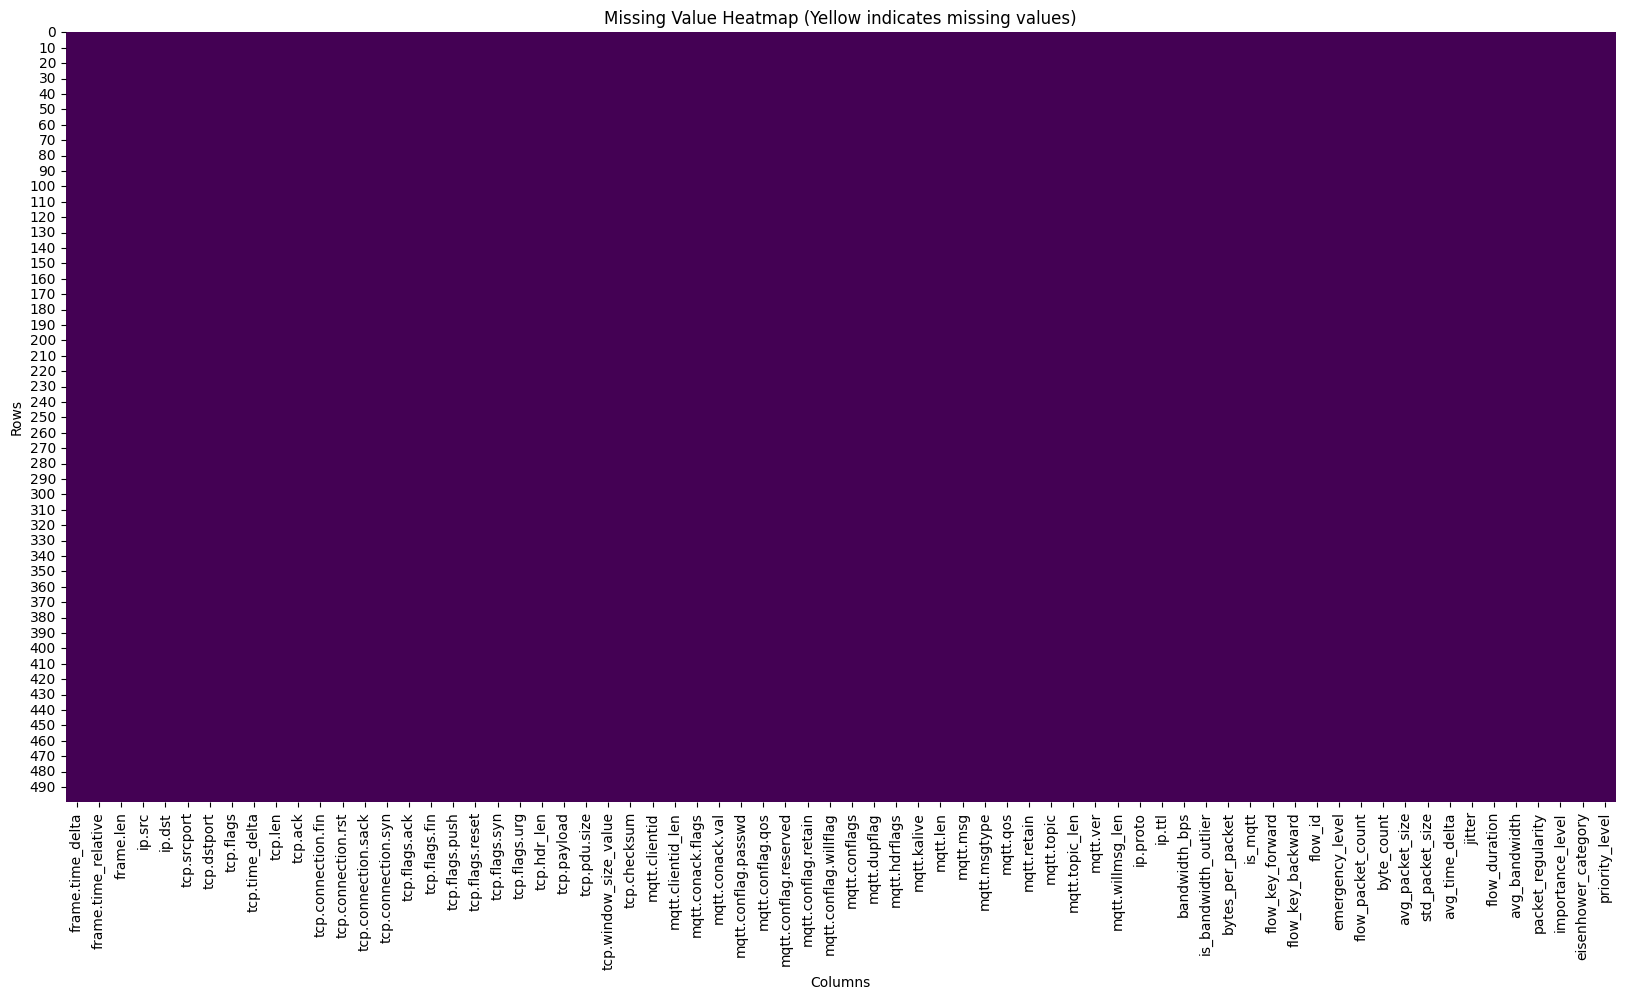

In [39]:
    # Example function to visualize missing values using a heatmap (if needed)
    #def plot_missing_values(df, max_rows=None):
    """
    Create a heatmap visualization of missing values in the dataframe.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to analyze for missing values
    max_rows : int, optional
        Maximum number of rows to display in the heatmap (useful for large datasets)

    Returns:
    --------
    None, displays a heatmap
    """
    max_rows = 500
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Use a subset of rows if needed
        if max_rows is not None and len(df) > max_rows:
            plot_df = df.iloc[:max_rows, :]
        else:
            plot_df = df

        # Create a binary mask of missing values
        missing_mask = plot_df.isnull()

        plt.figure(figsize=(20, 10))
        sns.heatmap(missing_mask, cbar=False, cmap='viridis')
        plt.title('Missing Value Heatmap (Yellow indicates missing values)')
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.show()

    except ImportError:
        print("Matplotlib and/or Seaborn are required for plotting. Please install with:")
        print("pip install matplotlib seaborn")

    # Example usage:
    # df, missing_stats = preprocess_network_data("network_traffic.csv", low_memory=False)
    #
    # # Optionally visualize missing values
    # plot_missing_values(df, max_rows=500)